In [1]:
import torch
from torch_geometric.data import Data

import torch.nn as nn
import torch_geometric.nn as pyg_nn

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import numpy as np

In [2]:
print("PyTorch Version:", torch.__version__)  # Check PyTorch version
print("CUDA Available:", torch.cuda.is_available())  # Check if CUDA is available
print("CUDA Version:", torch.version.cuda)  # Check the CUDA version used by PyTorch
print("GPU Count:", torch.cuda.device_count())  # Number of available GPUs
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))  # Name of the first GPU


PyTorch Version: 2.5.1
CUDA Available: True
CUDA Version: 12.4
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 2060


In [35]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NVIDIA GeForce RTX 2060
Using device: cuda


In [66]:
# Constants
L = 1.0
EI = 1
Q = -1

num_nodes = 100
dx = L / (num_nodes - 1) # Distance between nodes

In [ ]:
edge_index = []

for i in range(num_nodes - 1):
    edge_index.append([i, i + 1])  # Forward connection
    edge_index.append([i + 1, i])  # Backward connection

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)


node_pos = torch.tensor([[i * dx] for i in range(num_nodes)], dtype=torch.float)  
bc = torch.zeros((num_nodes, 1))
forces = torch.full((num_nodes, 1), Q)
lbc = (node_pos == 0)
rbc = (node_pos == 1)

bc[lbc] = 1
bc[rbc] = 2

x = torch.cat((node_pos, bc, forces), dim=1)

beam_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
beam_graph.x.requires_grad = True

q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q

x = beam_graph.x[:,0:1].detach()
exact = q1(x)

In [62]:

# Define the GNN model
class BeamGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BeamGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv4 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv5 = pyg_nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.tanh(self.conv1(x, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        x = torch.tanh(self.conv3(x, edge_index))
        x = torch.tanh(self.conv4(x, edge_index))
        x = self.conv5(x, edge_index)  # Output: Predicted displacements

        # Enforce boundary conditions
        x[data.x[:, 1] == 1] = 0  # Left boundary (assuming displacement is zero)
        x[data.x[:, 1] == 2] = q1(1)  # Right boundary (apply exact solution)
        
        return x



In [61]:
class PINN_graph():
    def __init__(self, graph):
        
        self.graph = graph

        self.input_dim = 3
        self.hidden_dim = 64
        self.output_dim = 1

        self.gnn = BeamGNN(self.input_dim, self.hidden_dim, self.output_dim)

        self.optimizer = torch.optim.Adam(self.gnn.parameters(), lr=0.01)
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.gnn.parameters(),
            lr=0.01,
            max_iter=5000,
            max_eval=5000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )
        self.iter = 0

    def model_value(self, graph):
        u = self.gnn(graph)
        return u
    
    def loss_func(self, graph):
        u = self.model_value(graph)

        loss = nn.MSELoss()

        output = loss(u, exact)

        return output
    
    def lbfgs_func(self):
        loss = self.loss_func(self.graph)
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss



    def train(self, epochs=1000):
        self.gnn.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_func(self.graph)
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)



In [69]:
model = PINN_graph(beam_graph)
print(model.gnn)

BeamGNN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 1)
)


In [70]:
model.train(5000)

Epoch: 0, Loss: 1.666708e-02
Epoch: 100, Loss: 2.716510e-05
Epoch: 200, Loss: 2.094393e-05
Epoch: 300, Loss: 2.059833e-05
Epoch: 400, Loss: 2.019277e-05
Epoch: 500, Loss: 1.973199e-05
Epoch: 600, Loss: 1.921210e-05
Epoch: 700, Loss: 1.862019e-05
Epoch: 800, Loss: 1.793167e-05
Epoch: 900, Loss: 1.710536e-05
Epoch: 1000, Loss: 1.607495e-05
Epoch: 1100, Loss: 1.473588e-05
Epoch: 1200, Loss: 1.293246e-05
Epoch: 1300, Loss: 1.047768e-05
Epoch: 1400, Loss: 7.331234e-06
Epoch: 1500, Loss: 4.112307e-06
Epoch: 1600, Loss: 2.131965e-06
Epoch: 1700, Loss: 1.564785e-06
Epoch: 1800, Loss: 1.474334e-06
Epoch: 1900, Loss: 1.445327e-06
Epoch: 2000, Loss: 1.420255e-06
Epoch: 2100, Loss: 1.395194e-06
Epoch: 2200, Loss: 1.370074e-06
Epoch: 2300, Loss: 1.344991e-06
Epoch: 2400, Loss: 1.320071e-06
Epoch: 2500, Loss: 1.295404e-06
Epoch: 2600, Loss: 1.271094e-06
Epoch: 2700, Loss: 1.247232e-06
Epoch: 2800, Loss: 1.223882e-06
Epoch: 2900, Loss: 1.201096e-06
Epoch: 3000, Loss: 1.178920e-06
Epoch: 3100, Loss: 1

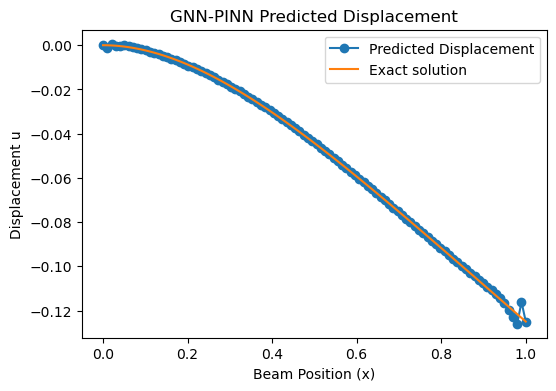

In [71]:
import matplotlib.pyplot as plt
model.gnn.eval()
# Get predictions
u = model.model_value(beam_graph)
u_pred = u.detach().cpu().numpy()



x = beam_graph.x[:,0:1]
x_pred = x.detach().cpu().numpy()

plt.figure(figsize=(6, 4))
plt.plot(x_pred, u_pred, 'o-', label="Predicted Displacement")
plt.plot(x_pred, exact.numpy(), label="Exact solution")
# plt.xlim([0,0.2])
plt.xlabel("Beam Position (x)")
plt.ylabel("Displacement u")
plt.title("GNN-PINN Predicted Displacement")
plt.legend()
plt.show()
